In [1]:
SAVE = False

Combine relevant evaluation files into a single file

In [2]:
import sys
sys.path.append('..')
import os
import pandas as pd
import eval_reallabor_utils
import data_utils

MRT = [2, 3]
combined_eval_file = []

for mrt in MRT:

    results_dirs = [
        f'v3_MRT{mrt}_VAR_10splits_train_len/00_summary_7stepsahead_interv',
        f'v3_MRT{mrt}_Kalman_10splits_train_len/00_summary_7stepsahead_interv',
        f'v3_MRT{mrt}_10splits_train_len/00_summary_7stepsahead_interv',
        ]    

    eval_files = []
    for rd in results_dirs:
        eval_files.append(data_utils.join_ordinal_bptt_path('results', rd, 'evaluation.csv'))
        assert os.path.exists(eval_files[-1]), f'{eval_files[-1]} does not exist'
    eval_reallabor_utils.clear_line_and_print(f'Combining evaluation files')
    mrt_combined_eval_file = eval_reallabor_utils.combine_evaluation_files(eval_files, 
                                                                        save_path=None,
                                                                        specifier_name='latent_model')
    mrt_combined_eval_file['MRT'] = mrt
    mrt_combined_eval_file['prediction'] = mrt_combined_eval_file['prediction'].clip(0, 8)

    combined_eval_file.append(mrt_combined_eval_file)

eval_reallabor_utils.clear_line_and_print(f'Creating grand combined evaluation file')
combined_eval_file = pd.concat(combined_eval_file, axis=0, ignore_index=False)

combined_eval_file = eval_reallabor_utils.include_exclude_hypers(combined_eval_file, {}, {'train_on_last_n_steps': 20})

if not os.path.exists(data_utils.join_ordinal_bptt_path('results/_paper/combined_10splits_train_len_ensemble.csv')):
    os.makedirs(data_utils.join_ordinal_bptt_path('results/_paper'), exist_ok=True)
    combined_eval_file.to_csv(data_utils.join_ordinal_bptt_path('results/_paper/combined_10splits_train_len_ensemble.csv'))

Creating grand combined evaluation file                                                                                                                                                                 

Calculate metrics and CIs

In [3]:
from eval_reallabor import reallabor_metrics
m_manager = reallabor_metrics.MetricsManager(combined_eval_file, ['latent_model', 'train_on_last_n_steps'], include_r2=False, only_nonzero_differences=False)

In [4]:
metrics, errorbars = {}, {}
metrics['mae'] = m_manager.mae(func='mean')
errorbars['mae'] = m_manager.mae(func='sem')
metrics['diff mae'] = m_manager.diff_mae(func='mean')
errorbars['diff mae'] = m_manager.diff_mae(func='sem')
metrics['interv mae'] = m_manager.interv_mae(func='mean')
errorbars['interv mae'] = m_manager.interv_mae(func='sem')
metrics[r'interv. effect mae'] = m_manager.interv_diff_mae(func='mean')
errorbars[r'interv. effect mae'] = m_manager.interv_diff_mae(func='sem')

Plot MAE

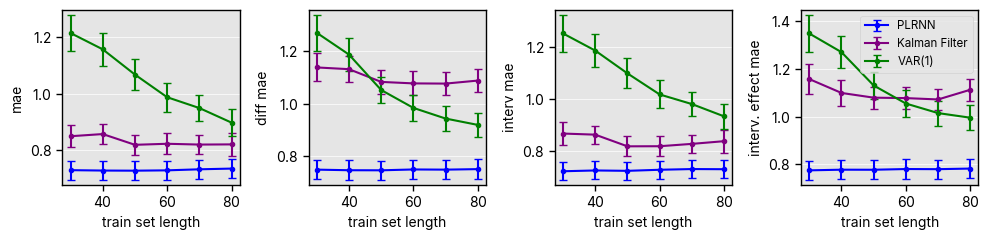

In [5]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from plotting_styles import PaperStyle, colors
from plotting_utils import adjust_ylim

model_labels = {
                    'clipped-shallow-PLRNN': 'PLRNN', 
                    'KalmanFilter': 'Kalman Filter',
                    'VAR1': 'VAR(1)'                 
                    }

with PaperStyle():

    fig, axes = plt.subplots(1, len(metrics), figsize=(10, 2.5), sharex=True)

    for i, m in enumerate(metrics):
        for j, model in enumerate(model_labels.keys()):
            # for mrt in MRT:
            this_line = metrics[m].loc[(model)]
            this_errorbars = errorbars[m].loc[(model)].T
            axes[i].errorbar(this_line.index, this_line, yerr=this_errorbars, marker='.', capsize=3, label=model_labels[model], color=colors.model_colors[model])
        adjust_ylim(axes[i], 0.03, 0.03)
        axes[i].set(ylabel=m, xlabel='train set length')
    axes[-1].legend()
    plt.tight_layout()
    if SAVE:
        plt.savefig(f'../results/_paper/determinants_of_forecasting_quality/train_len_10splits.svg', dpi=300)
    
    plt.show()

Number of samples involved in the calculations

In [7]:
characteristics = []
for eval_file in [combined_eval_file]:

    samples = {
        'subjects': eval_file.groupby(['MRT'])['participant'].nunique(),
        'days_total': eval_file.groupby(['MRT', 'participant'])['test_day'].nunique().unstack('MRT').sum(),
        'days_median': eval_file.groupby(['MRT', 'participant'])['test_day'].nunique().unstack('MRT').median(),
        'days_q25': eval_file.groupby(['MRT', 'participant'])['test_day'].nunique().unstack('MRT').quantile(0.25),
        'days_q75': eval_file.groupby(['MRT', 'participant'])['test_day'].nunique().unstack('MRT').quantile(0.75),
        'samples_total': eval_file.groupby(['MRT', 'participant', 'test_day', 'steps'])['ground_truth'].mean().unstack('MRT').count()
    }

    characteristics.append(pd.DataFrame(samples))
characteristics = pd.concat(characteristics, axis=0, names=['MRT'])
characteristics

,subjects,days_total,days_median,days_q25,days_q75,samples_total
MRT,,,,,,
2,20,197.0,10.0,10.0,10.0,1124
3,17,170.0,10.0,10.0,10.0,1004


Stability of training by network similarity across runs

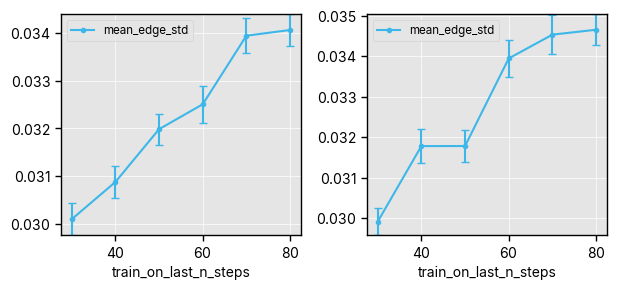

In [7]:
import sys
sys.path.append('..')
from tqdm import tqdm
import torch as tc
import matplotlib.pyplot as plt
from plotting_styles import PaperStyle
import eval_reallabor_utils
import data_utils
from bptt.plrnn import PLRNN

sys.path.append(data_utils.join_base_path('reallaborai4u/preprocessing'))
from feature_names import NON_CONDITIONAL_FEAT as LABELS
from feature_names import CONSTRUCTS_ANY_NON_CONDITIONAL as CONSTRUCTS
CONSTRUCTS = [c.lower() for c in CONSTRUCTS]
from feature_names import FLIP_OBSERVATION
NEGATIVE_ITEMS = [i for i in range(len(LABELS)) if LABELS[i] in FLIP_OBSERVATION]

MRT = [2, 3]
train_lengths = combined_eval_file['train_on_last_n_steps'].unique()
network_edge_std = []
for mrt in MRT:
    results_dir = data_utils.join_ordinal_bptt_path('results', f'v2_MRT{mrt}_10splits_train_len')
    test_data_dir = data_utils.dataset_path(mrt, 'processed_csv_no_con')
    models = eval_reallabor_utils.ModelCatalogue(results_dir)
    for pid, df in data_utils.zip_participants_data(test_data_dir):
        for T in train_lengths:            
            local_catalogue = models.catalogue.loc[(models.catalogue['participant']==pid) & (models.catalogue['train_on_last_n_steps']==T)]
            for split, group in local_catalogue.groupby('model_timestep'):
                model_dirs = group['model_dir'].to_list()
                config_networks = []
                for model_dir in model_dirs:
                    model = PLRNN()
                    model.init_from_model_path(model_dir)
                    x = tc.tensor(df[LABELS].to_numpy()).float()
                    network = eval_reallabor_utils.get_network_matrix(model, x).nanmean(0)
                    config_networks.append(network)
                config_mean_edge_std = tc.stack(config_networks, dim=0).std(0).mean().detach().numpy()
                network_edge_std.append({'MRT': mrt, 'participant': pid, 'train_on_last_n_steps': T, 'train_on_data_until_timestep': split, 'mean_edge_std': config_mean_edge_std})                
network_edge_std = pd.DataFrame(network_edge_std)
network_edge_std = network_edge_std.set_index(['MRT', 'participant', 'train_on_last_n_steps', 'train_on_data_until_timestep'])

with PaperStyle():

    fig, axes = plt.subplots(1, 2, figsize=(6.27, 3), sharex=True)
    for i, mrt in enumerate(MRT):
        mean_network_edge_std = network_edge_std.loc[mrt].groupby('train_on_last_n_steps').mean()
        sem_network_edge_std = network_edge_std.loc[mrt].groupby('train_on_last_n_steps').sem()
        mean_network_edge_std.plot(ax=axes[i], yerr=sem_network_edge_std, marker='.', capsize=3)     
    plt.tight_layout()   
    plt.show()
